In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from geopy import distance

from tqdm import trange
from sklearn.metrics.pairwise import euclidean_distances
import torch

### Load auxiliary data

In [5]:
coe_prices = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-coe-prices.csv")
existing_mrt = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-mrt-existing-stations.csv")
future_mrt = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-mrt-planned-stations.csv")
schools = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-primary-schools.csv")
malls = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-shopping-malls.csv")
stock = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-stock-prices.csv")

### Load Preprocessed Data

In [6]:
dataset = pd.read_csv("data/train_preprocessed.csv")
dataset.head()

,rent_approval_date,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,planning_area,region,monthly_rent,rent_approval_year,rent_approval_month,flat_type_2-room,flat_type_3-room,flat_type_4-room,flat_type_5-room,flat_type_executive,flat_model_cat
0,2021-09,new generation,67.0,1983,1.344518,103.738630,jurong east,west region,1600,2021,9,0,1,0,0,0,0
1,2022-05,new generation,92.0,1978,1.330186,103.938717,bedok,east region,2250,2022,5,0,0,1,0,0,0
2,2022-10,improved,67.0,1971,1.332242,103.845643,toa payoh,central region,1900,2022,10,0,1,0,0,0,1
3,2021-08,apartment,149.0,1993,1.370239,103.962894,pasir ris,east region,2850,2021,8,0,0,0,0,1,2
4,2022-11,improved,68.0,1972,1.320502,103.863341,kallang,central region,2100,2022,11,0,1,0,0,0,1


### Separate Data According To Their Flat Type

In [5]:
rm2 = dataset.loc[dataset["flat_type_2-room"]==1]
rm3 = dataset.loc[dataset["flat_type_3-room"]==1]
rm4 = dataset.loc[dataset["flat_type_3-room"]==1]
rm5 = dataset.loc[dataset["flat_type_3-room"]==1]
ea = dataset.loc[dataset["flat_type_executive"]==1]

### Calculate the median rental in each month for each flat type

In [12]:
rms = {"2-room": rm2, "3-room": rm3, "4-room": rm4, "5-room": rm5, "executive": ea}
median_prices = {}
for rm in rms.keys():
    ft = rms[rm]
    median_prices[rm] = []
    for y in [2021, 2022, 2023]:
        yearly_data = ft.loc[ft['rent_approval_year']==y]
        for m in range(1, 13):
            if m in yearly_data['rent_approval_month'].unique():
                monthly_data = yearly_data.loc[yearly_data['rent_approval_month']==m]
                median_rent = monthly_data['monthly_rent'].median()
                median_prices[rm].append(median_rent)
                median_prices[rm].append(median_rent)

median_prices

{'2-room': [1600.0,
  1600.0,
  1450.0,
  1450.0,
  1600.0,
  1600.0,
  1400.0,
  1400.0,
  1450.0,
  1450.0,
  1700.0,
  1700.0,
  1600.0,
  1600.0,
  1600.0,
  1600.0,
  1600.0,
  1600.0,
  1600.0,
  1600.0,
  1700.0,
  1700.0,
  1650.0,
  1650.0,
  1625.0,
  1625.0,
  1600.0,
  1600.0,
  1750.0,
  1750.0,
  1600.0,
  1600.0,
  1875.0,
  1875.0,
  1950.0,
  1950.0,
  1750.0,
  1750.0,
  1900.0,
  1900.0,
  2050.0,
  2050.0,
  1750.0,
  1750.0,
  2500.0,
  2500.0,
  2200.0,
  2200.0,
  2300.0,
  2300.0,
  2500.0,
  2500.0,
  2300.0,
  2300.0,
  2400.0,
  2400.0,
  2450.0,
  2450.0,
  2450.0,
  2450.0,
  2400.0,
  2400.0],
 '3-room': [1900.0,
  1900.0,
  1900.0,
  1900.0,
  1900.0,
  1900.0,
  1900.0,
  1900.0,
  1900.0,
  1900.0,
  1950.0,
  1950.0,
  2000.0,
  2000.0,
  2000.0,
  2000.0,
  1950.0,
  1950.0,
  2000.0,
  2000.0,
  2050.0,
  2050.0,
  2050.0,
  2050.0,
  2100.0,
  2100.0,
  2100.0,
  2100.0,
  2100.0,
  2100.0,
  2100.0,
  2100.0,
  2200.0,
  2200.0,
  2200.0,
  2200.0,

### Inspect COE Price Trend

In [13]:
coe_prices.head()

,year,category,month,bidding,price,quota,bids
0,2023,a,july,2,95202,581,728
1,2023,a,july,1,97000,588,756
2,2023,a,june,2,96206,586,751
3,2023,a,june,1,98001,581,881
4,2023,a,may,2,92000,596,936


In [14]:
months = {
    "january": 1,
    "february": 2,
    "march": 3,
    "april": 4,
    "may": 5,
    "june": 6,
    "july": 7,
    "august": 8,
    "september": 9,
    "october": 10,
    "november": 11,
    "december": 12
}

coe_prices['month'] = coe_prices['month'].apply(lambda x: months[x])
coe_prices["date"] = pd.to_datetime(coe_prices[["year", "month"]].assign(DAY=1))
coe_prices["date"] = np.where(coe_prices["bidding"]==2, coe_prices['date']+pd.DateOffset(days=15), coe_prices['date'])
coe_prices["date"] = coe_prices["date"].dt.strftime('%Y-%m-%d')
coe_prices.dtypes


year         int64
category    object
month        int64
bidding      int64
price        int64
quota        int64
bids         int64
date        object
dtype: object

In [15]:
coe_prices.sort_values(by='date', ascending=True)
coe_prices_a = coe_prices.loc[coe_prices['category']=='a']
coe_prices_b = coe_prices.loc[coe_prices['category']=='b']
coe_prices_c = coe_prices.loc[coe_prices['category']=='c']
coe_prices_e = coe_prices.loc[coe_prices['category']=='e']
coe_prices['category'].unique()

array(['a', 'b', 'c', 'e'], dtype=object)

TypeError: the first argument to axis() must be an iterable of the form [xmin, xmax, ymin, ymax]

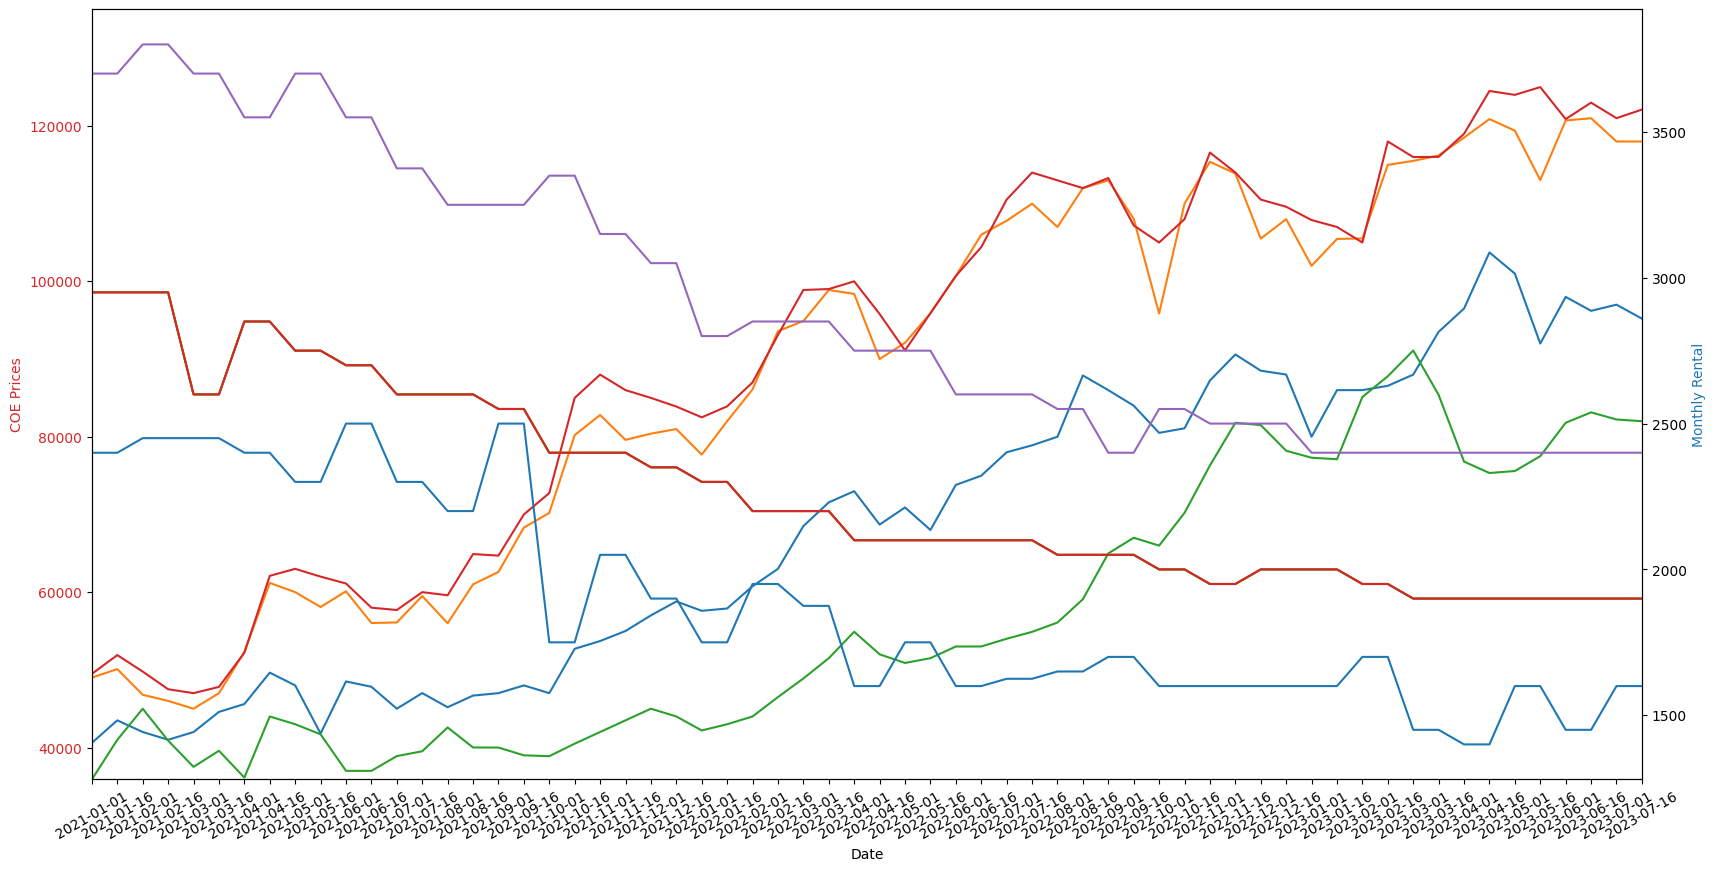

In [23]:
fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)


color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('COE Prices', color=color)
ax1.plot(coe_prices_a["date"], coe_prices_a["price"])
ax1.plot(coe_prices_b["date"], coe_prices_b["price"])
ax1.plot(coe_prices_c["date"], coe_prices_c["price"])
ax1.plot(coe_prices_e["date"], coe_prices_e["price"])
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=30)
ax1.axis([min(coe_prices_a["date"]), max(coe_prices_a["date"]), min(coe_prices["price"]), max(coe_prices["price"])+10000])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('Monthly Rental', color=color)  # we already handled the x-label with ax1
# for k in median_prices.keys():
#     ax2.plot(coe_prices_a["date"], median_prices[k])
# ax2.axis([[min(coe_prices_a["date"]), max(coe_prices_a["date"]), 0, 7000]])
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

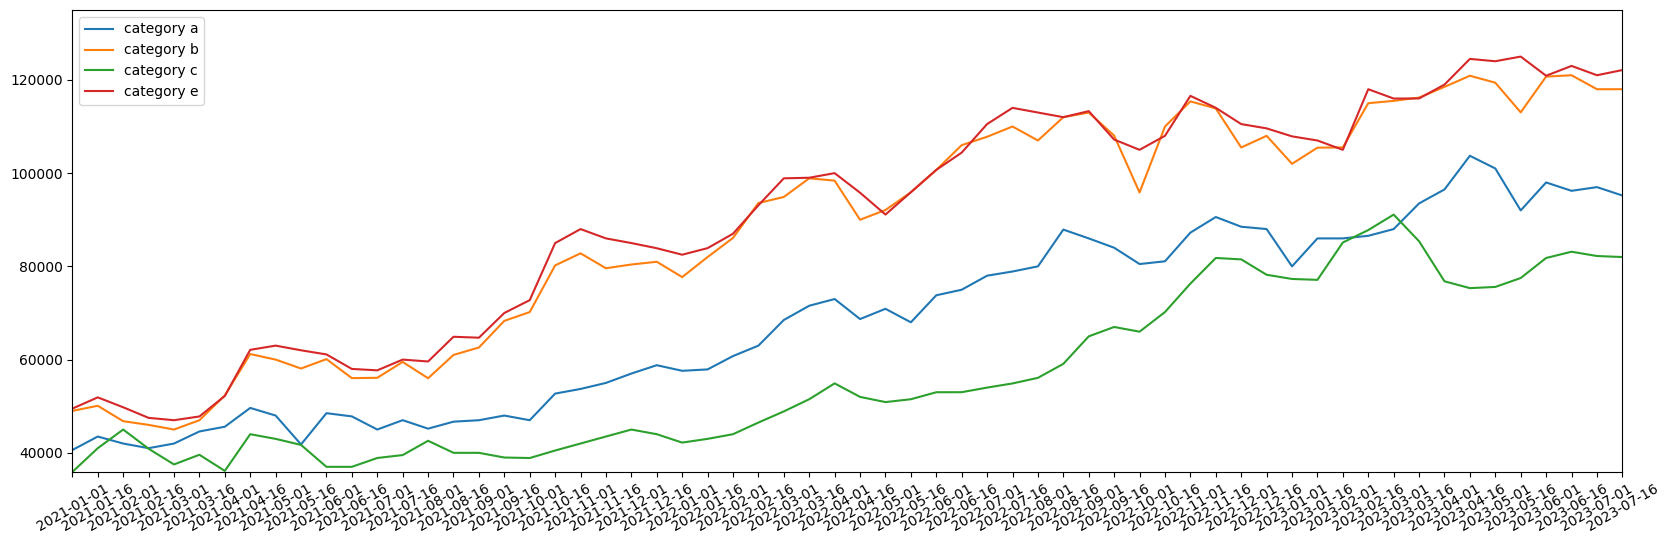

In [11]:
plt.figure(figsize=(20, 6))
plt.plot(coe_prices_a["date"], coe_prices_a["price"])
plt.plot(coe_prices_b["date"], coe_prices_b["price"])
plt.plot(coe_prices_c["date"], coe_prices_c["price"])
plt.plot(coe_prices_e["date"], coe_prices_e["price"])
plt.xticks(coe_prices_a["date"], rotation=30)
plt.axis([min(coe_prices_a["date"]), max(coe_prices_a["date"]), min(coe_prices["price"]), max(coe_prices["price"])+10000])
plt.legend(['category a', 'category b', 'category c', 'category e'])

### Plot Price to Location for Each House

<Axes: xlabel='longitude', ylabel='latitude'>

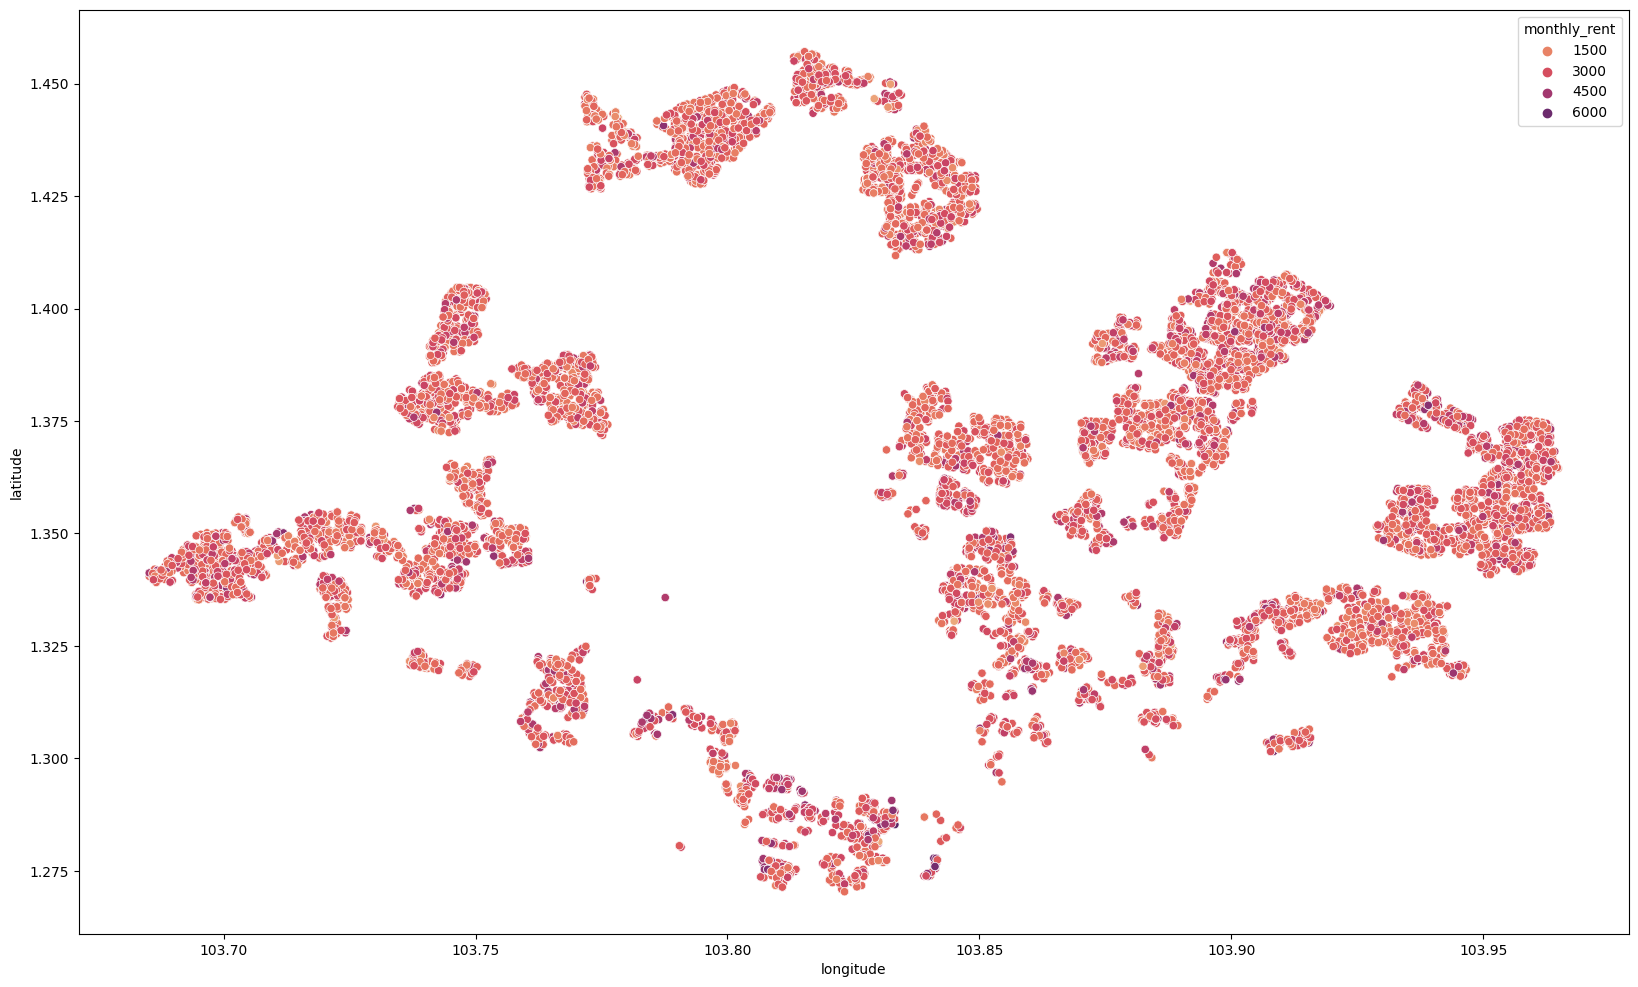

In [26]:
plt.figure(figsize=(20, 12))
sns.scatterplot(dataset, x="longitude", y="latitude", hue="monthly_rent", palette="flare")

### Plot Locations of Places of Interest

In [147]:
existing_mrt


,code,name,opening_year,latitude,longitude
0,NS1,Jurong East,1990,1.333295,103.742154
1,NS2,Bukit Batok,1990,1.349035,103.749526
2,NS3,Bukit Gombak,1990,1.358663,103.751913
3,NS4,Choa Chu Kang,1990,1.385363,103.744371
4,NS5,Yew Tee,1996,1.397476,103.747418
...,...,...,...,...,...
157,TE17,Outram Park,2022,1.280242,103.840052
158,TE18,Maxwell,2022,1.280533,103.843884
159,TE19,Shenton Way,2022,1.277717,103.850368
160,TE20,Marina Bay,2022,1.276311,103.854605


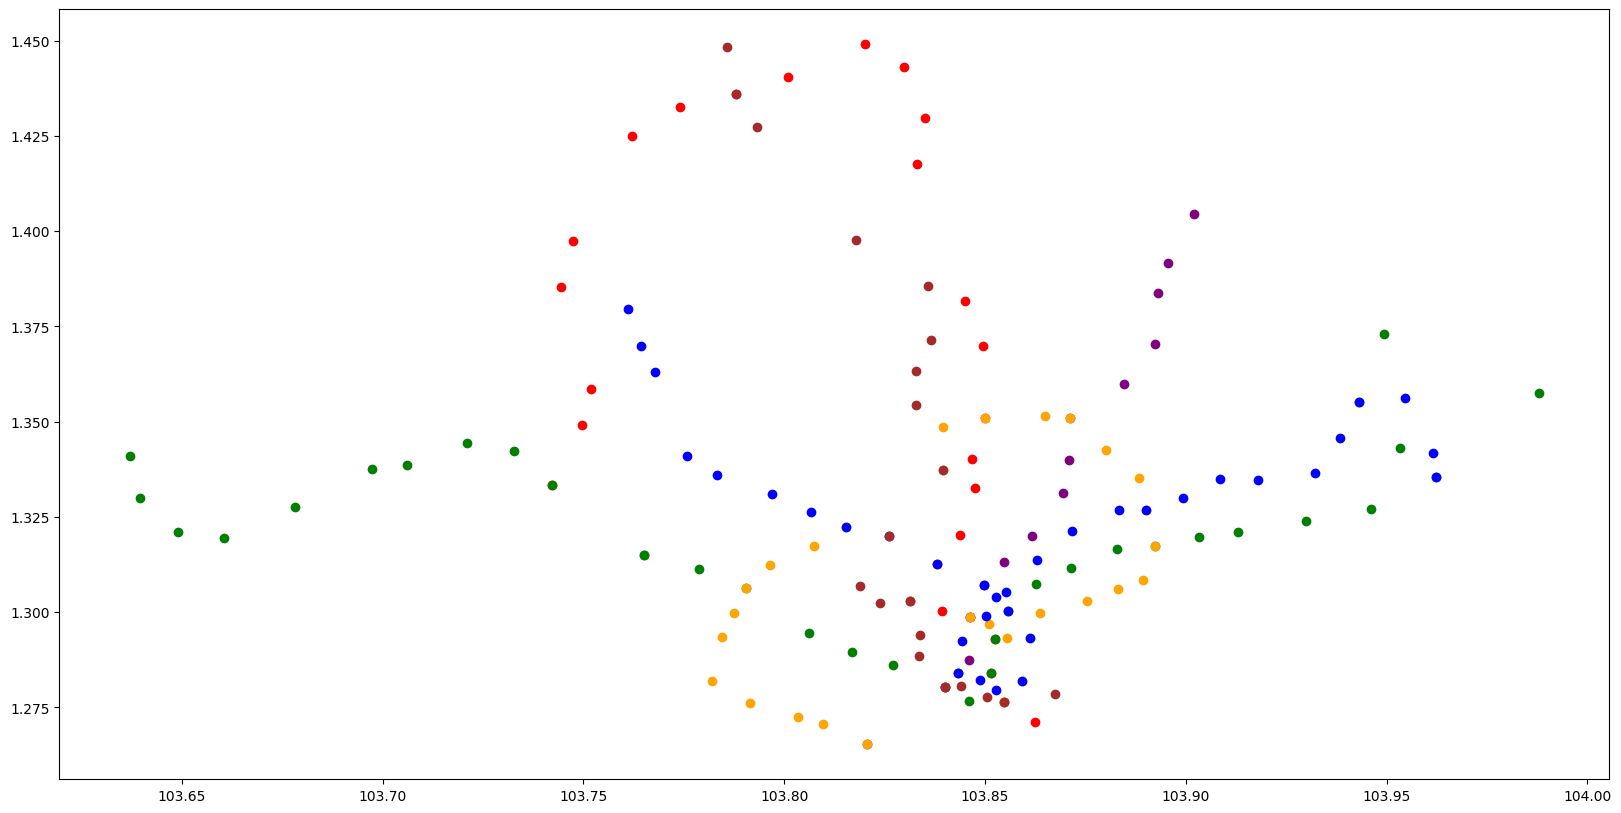

In [146]:
plt.figure(figsize=(20,10))
mrt_colours = {"NS": "red", "EW": "green", "CG": "green", "NE": "purple", "CC": "orange", "DT": "blue", "TE": "brown", "CE": "orange"}
for i in range(len(existing_mrt)):
    code = existing_mrt.loc[i, "code"][:2]
    color = mrt_colours[code]
    plt.scatter(x=existing_mrt.loc[i, "longitude"], y=existing_mrt.loc[i, "latitude"], c=color)
    

In [135]:
future_mrt.head()


,code,name,opening_year,latitude,longitude
0,NaN,Brickland,2030,1.369700,103.747900
1,NaN,Sungei Kadut,2030,1.413300,103.748800
2,NaN,Punggol Coast,2024,1.415280,103.911110
3,NaN,Bukit Brown,TBA,1.333639,103.830075
4,NaN,Keppel,2026,1.270100,103.831000


In [136]:
malls.head()

,name,latitude,longitude
0,100 AM,1.274588,103.843471
1,313@Somerset,1.301385,103.837684
2,Aperia,1.310867,103.863930
3,Balestier Hill Shopping Centre,1.325596,103.842572
4,Bugis Cube,1.298141,103.855635


In [137]:
schools.head()

,name,latitude,longitude
0,Admiralty Primary School,1.454038,103.817436
1,Ahmad Ibrahim Primary School,1.433153,103.832942
2,Ai Tong School,1.360583,103.833020
3,Alexandra Primary School,1.291334,103.824425
4,Anchor Green Primary School,1.390370,103.887165


### Print monthly rent price distribution

Average monthly rent value: 2590.3283333333334
Median monthly rent value: 2400.0


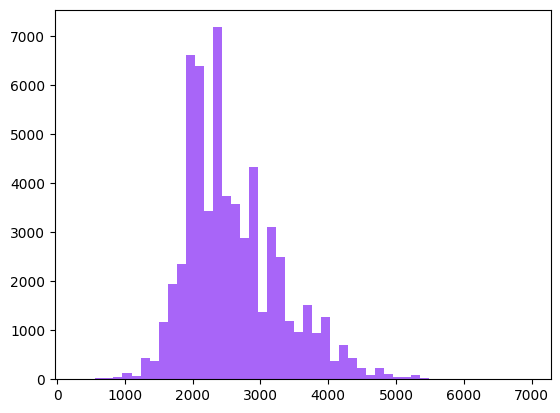

In [7]:
print("Average monthly rent value: {}".format(dataset['monthly_rent'].mean()))
print("Median monthly rent value: {}".format(dataset['monthly_rent'].median()))
plt.hist(dataset['monthly_rent'], color='#a865f8', bins=50)
plt.show()

### Print skewness value in each column

In [8]:
dataset.skew()

/home/thong/library/cs5228_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


floor_area_sqm         0.238213
lease_commence_date    0.298661
latitude               0.242286
longitude             -0.230824
monthly_rent           0.864935
rent_approval_year     0.338865
rent_approval_month    0.289192
flat_type_2-room       7.857716
flat_type_3-room       0.796798
flat_type_4-room       0.561665
flat_type_5-room       1.179668
flat_type_executive    3.750997
flat_model_cat         0.687331
dtype: float64

### Relation between the distance of the flat from the MRT/School/Mall and its rental price

### a) MRT

In [92]:
flat_latitude_list = list(dataset['latitude'])
flat_longtitude_list = list(dataset['longitude'])
flat_coordinates = [flat_latitude_list, flat_longtitude_list]
monthly_rent_list = list(dataset['monthly_rent'])

mrt_latitude_list = list(existing_mrt['latitude'])
mrt_longitude_list = list(existing_mrt['longitude'])
mrt_coordinates = [mrt_latitude_list, mrt_longitude_list]

In [96]:
flat_mrt_distances = []

for i in trange(len(flat_coordinates[0])):
    distance_list = []
    flat = (flat_coordinates[0][i], flat_coordinates[1][i])
    for j in range(len(mrt_coordinates[0])):
        mrt = (mrt_coordinates[0][j], mrt_coordinates[1][j])
        dist = distance.distance(flat, mrt).km
        distance_list.append(dist)
    flat_mrt_distances.append(distance_list)
    
flat_mrt_distance_tensor = torch.tensor(flat_mrt_distances)
flat_mrt_min_dist_tensor, _ = flat_mrt_distance_tensor.min(dim=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [28:46<00:00, 34.76it/s]


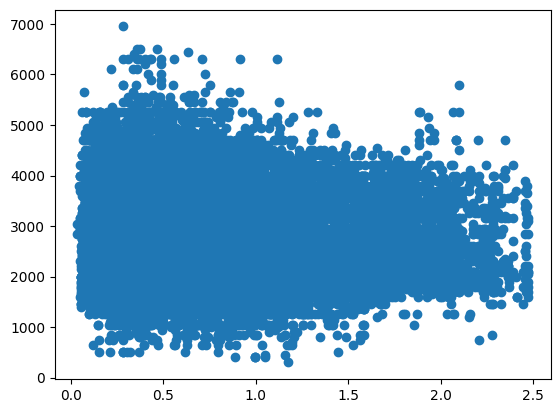

In [104]:
plt.scatter(flat_mrt_min_dist_tensor.tolist(), monthly_rent_list)
plt.show()

### b) School

In [106]:
flat_latitude_list = list(dataset['latitude'])
flat_longtitude_list = list(dataset['longitude'])
flat_coordinates = [flat_latitude_list, flat_longtitude_list]
monthly_rent_list = list(dataset['monthly_rent'])

school_latitude_list = list(schools['latitude'])
school_longitude_list = list(schools['longitude'])
school_coordinates = [school_latitude_list, school_longitude_list]

In [107]:
flat_school_distances = []

for i in trange(len(flat_coordinates[0])):
    distance_list = []
    flat = (flat_coordinates[0][i], flat_coordinates[1][i])
    for j in range(len(school_coordinates[0])):
        school = (school_coordinates[0][j], school_coordinates[1][j])
        dist = distance.distance(flat, school).km
        distance_list.append(dist)
    flat_school_distances.append(distance_list)
    
flat_school_distance_tensor = torch.tensor(flat_school_distances)
flat_school_min_dist_tensor, _ = flat_school_distance_tensor.min(dim=1)

100%|███████████| 60000/60000 [32:32<00:00, 30.74it/s]


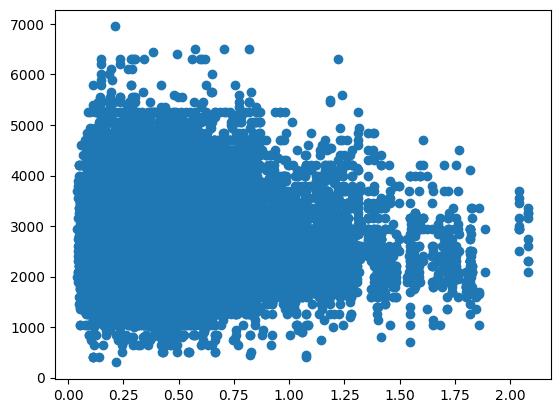

In [110]:
plt.scatter(flat_school_min_dist_tensor.tolist(), monthly_rent_list)
plt.show()

### c) Mall

In [112]:
flat_latitude_list = list(dataset['latitude'])
flat_longtitude_list = list(dataset['longitude'])
flat_coordinates = [flat_latitude_list, flat_longtitude_list]
monthly_rent_list = list(dataset['monthly_rent'])

mall_latitude_list = list(malls['latitude'])
mall_longitude_list = list(malls['longitude'])
mall_coordinates = [mall_latitude_list, mall_longitude_list]

In [115]:
flat_mall_distances = []

for i in trange(len(flat_coordinates[0])):
    distance_list = []
    flat = (flat_coordinates[0][i], flat_coordinates[1][i])
    for j in range(len(mall_coordinates[0])):
        mall = (mall_coordinates[0][j], mall_coordinates[1][j])
        dist = distance.distance(flat, mall).km
        distance_list.append(dist)
    flat_mall_distances.append(distance_list)
    
flat_mall_distance_tensor = torch.tensor(flat_mall_distances)
flat_mall_min_dist_tensor, _ = flat_mall_distance_tensor.min(dim=1)

100%|███████████| 60000/60000 [28:47<00:00, 34.72it/s]


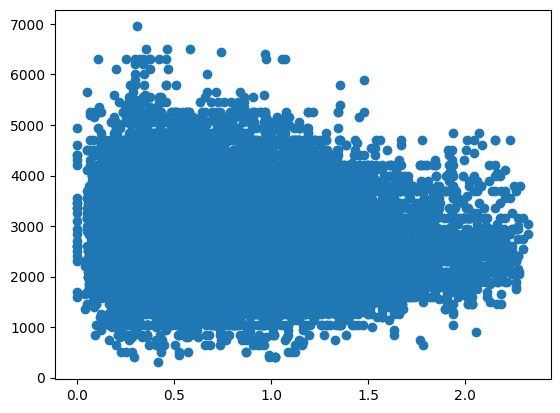

In [116]:
plt.scatter(flat_mall_min_dist_tensor.tolist(), monthly_rent_list)
plt.show()